In [44]:
import jax
jax.config.update("jax_enable_x64", True)
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = 'false'
import jax.numpy as jnp
from jax import jit,grad,jacfwd,jacrev,vmap
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from Kernels import *
from EquationModel import *
from jax.scipy.linalg import solve
from EquationModel import *

In [45]:
#u_data = jnp.load("darcy_example_data/u_vals.npy")
x_grid=jnp.linspace(0,1,100)
y_grid=jnp.linspace(0,1,100)
X,Y=jnp.meshgrid(x_grid,y_grid)

@jit
def u_true_function1(x1,x2):
    return jnp.exp(jnp.sin(1*(jnp.cos(2*x1) + jnp.cos(3*x2))))
def u_true_function2(x1,x2):
    return jnp.exp(0.2 * (jnp.sin(1*(jnp.cos(5*x1) - jnp.cos(4*x2)))))

def u_true_function3(x1,x2):
    return jnp.sin(2 * x1) * jnp.cos(3 * x2)

def A(x1,x2):
    return jnp.exp(jnp.sin(jnp.cos(x1) + jnp.cos(x2)))
    #return 2.

def A_times_grad_u1(x1,x2):
    grad_u = jacfwd(u_true_function1, argnums=[0,1])
    return A(x1,x2)*jnp.array(grad_u(x1,x2))
def A_times_grad_u2(x1,x2):
    grad_u = jacfwd(u_true_function2, argnums=[0,1])
    return A(x1,x2)*jnp.array(grad_u(x1,x2))
def A_times_grad_u3(x1,x2):
    grad_u = jacfwd(u_true_function3, argnums=[0,1])
    return A(x1,x2)*jnp.array(grad_u(x1,x2))

def rhs1(x1,x2):
    div = jacfwd(A_times_grad_u1, argnums=[0,1])
    return -jnp.trace(jnp.array(div(x1,x2)))
def eval_rhs1(pairs):
    return jnp.array(vmap(lambda t: rhs1(t[0], t[1]))(pairs))

def rhs2(x1,x2):
    div = jacfwd(A_times_grad_u2, argnums=[0,1])
    return -jnp.trace(jnp.array(div(x1,x2)))
def eval_rhs2(pairs):
    return jnp.array(vmap(lambda t: rhs2(t[0], t[1]))(pairs))

def rhs3(x1,x2):
    div = jacfwd(A_times_grad_u3, argnums=[0,1])
    return -jnp.trace(jnp.array(div(x1,x2)))
@jax.jit
def eval_rhs3(pairs):
    return jnp.array(vmap(lambda t: rhs3(t[0], t[1]))(pairs))

In [46]:
def build_xy_grid(x_range,y_range,num_grid_x,num_grid_y):
    full_x_grid = jnp.linspace(x_range[0],x_range[1],num_grid_x)
    full_y_grid = jnp.linspace(y_range[0],y_range[1],num_grid_y)


    x_interior = full_x_grid[1:-1]
    y_interior = full_y_grid[1:-1]
    
    x_boundary = full_x_grid[jnp.array([0,-1])]
    y_boundary = full_y_grid[jnp.array([0,-1])]

    #Get interior points
    x,y = jnp.meshgrid(x_interior,y_interior)
    xy_interior = jnp.vstack([x.flatten(),y.flatten()]).T

    #I'm doing this with meshgrid to handle more general higher dimensions, ie circular domain in 2d
    #Get boundary points
    x,y = jnp.meshgrid(x_interior,y_boundary)
    xy_boundary_1 = jnp.vstack([x.flatten(),y.flatten()]).T

    x,y = jnp.meshgrid(x_boundary,y_interior)
    xy_boundary_2 = jnp.vstack([x.flatten(),y.flatten()]).T

    x,y = jnp.meshgrid(x_boundary,y_boundary)
    xy_boundary_3 = jnp.vstack([x.flatten(),y.flatten()]).T

    xy_boundary = jnp.vstack([xy_boundary_1,xy_boundary_2,xy_boundary_3])
    return xy_interior,xy_boundary

In [47]:
num_grid_points = 17
# Ghost grid - Same per function
xy_int,xy_bdy = build_xy_grid([0,1],[0,1],num_grid_points,num_grid_points)
xy_all = jnp.vstack([xy_bdy,xy_int])


u_true1 = u_true_function1(xy_all[:,0],xy_all[:,1])
u_true2 = u_true_function2(xy_all[:,0],xy_all[:,1])
u_true3 = u_true_function3(xy_all[:,0],xy_all[:,1])


num_obs1 = 15
np.random.seed(20)
x_y_sample_inds1 = np.random.choice(list(np.arange(len(xy_int))),num_obs1,replace = False)
x_y_sample_inds1 = jnp.hstack([x_y_sample_inds1])
xy_obs1 = jnp.vstack([xy_bdy,xy_int[x_y_sample_inds1]])
u_obs1 = u_true_function1(xy_obs1[:,0],xy_obs1[:,1])

num_obs2 = 15
np.random.seed(21)
x_y_sample_inds2 = np.random.choice(list(np.arange(len(xy_int))),num_obs2,replace = False)
x_y_sample_inds2 = jnp.hstack([x_y_sample_inds2])
xy_obs2 = jnp.vstack([xy_bdy,xy_int[x_y_sample_inds2]])
u_obs2 = u_true_function2(xy_obs2[:,0],xy_obs2[:,1])

num_obs3 = 15
np.random.seed(22)
x_y_sample_inds3 = np.random.choice(list(np.arange(len(xy_int))),num_obs3,replace = False)
x_y_sample_inds3 = jnp.hstack([x_y_sample_inds3])
xy_obs3 = jnp.vstack([xy_bdy,xy_int[x_y_sample_inds3]])
u_obs3 = u_true_function3(xy_obs3[:,0],xy_obs3[:,1])

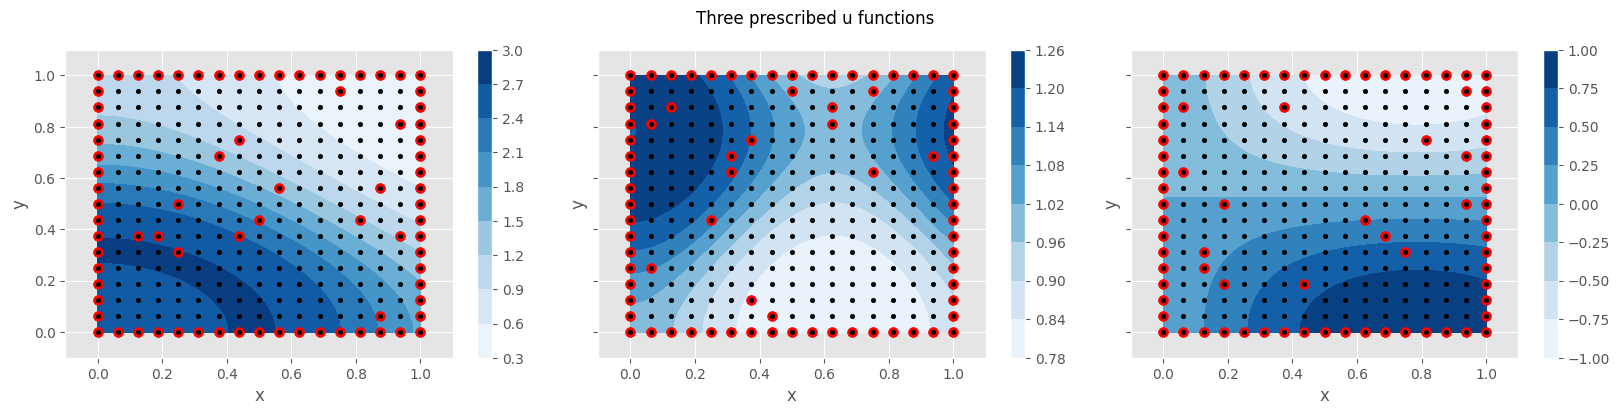

In [48]:
# Plot u's
num_fine_grid = 100
x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid),np.linspace(0,1,num_fine_grid))
xy_fine = np.vstack([x_fine.flatten(),y_fine.flatten()]).T


fig, axs = plt.subplots(figsize = (20,4), nrows =1 , ncols = 3, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('Three prescribed u functions')
axs0 = axs[0].tricontourf(xy_fine[:,0],xy_fine[:,1],u_true_function1(xy_fine[:,0],xy_fine[:,1]),cmap = 'Blues')
plt.colorbar(axs0, ax = axs[0])
axs[0].scatter(xy_obs1[:,0],xy_obs1[:,1],c='red', s = 50)
axs[0].scatter(xy_all[:,0],xy_all[:,1],c='black',s = 10)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_xlim(-0.1,1.1)
axs[0].set_ylim(-0.1,1.1)
axs1 = axs[1].tricontourf(xy_fine[:,0],xy_fine[:,1],u_true_function2(xy_fine[:,0],xy_fine[:,1]),cmap = 'Blues')
plt.colorbar(axs1, ax = axs[1])
axs[1].scatter(xy_obs2[:,0],xy_obs2[:,1],c='red', s = 50)
axs[1].scatter(xy_all[:,0],xy_all[:,1],c='black',s = 10)
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_xlim(-0.1,1.1)
axs[1].set_ylim(-0.1,1.1)
axs2 = axs[2].tricontourf(xy_fine[:,0],xy_fine[:,1],u_true_function3(xy_fine[:,0],xy_fine[:,1]),cmap = 'Blues')
plt.colorbar(axs2, ax = axs[2])
axs[2].scatter(xy_obs3[:,0],xy_obs3[:,1],c='red', s = 50)
axs[2].scatter(xy_all[:,0],xy_all[:,1],c='black',s = 10)
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_xlim(-0.1,1.1)
axs[2].set_ylim(-0.1,1.1)
plt.show()

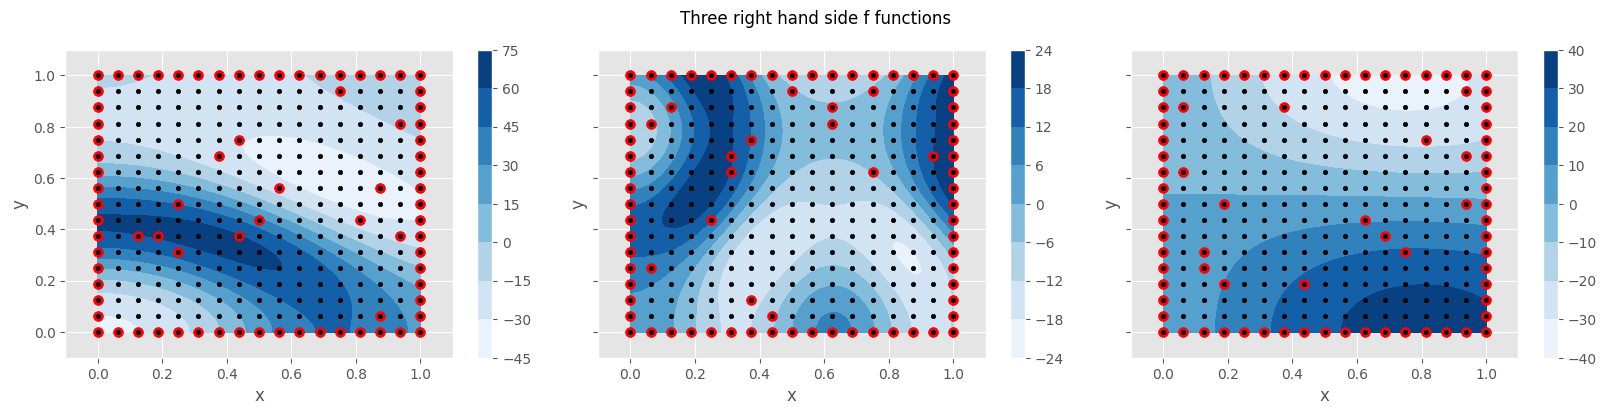

In [49]:
# Plot f's
num_fine_grid = 100
x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid),np.linspace(0,1,num_fine_grid))
xy_fine = np.vstack([x_fine.flatten(),y_fine.flatten()]).T

fig, axs = plt.subplots(figsize = (20,4), nrows =1 , ncols = 3, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('Three right hand side f functions')
axs0 = axs[0].tricontourf(xy_fine[:,0],xy_fine[:,1],eval_rhs1(xy_fine),cmap = 'Blues')
plt.colorbar(axs0, ax = axs[0])
axs[0].scatter(xy_obs1[:,0],xy_obs1[:,1],c='red', s = 50)
axs[0].scatter(xy_all[:,0],xy_all[:,1],c='black',s = 10)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_xlim(-0.1,1.1)
axs[0].set_ylim(-0.1,1.1)
axs1 = axs[1].tricontourf(xy_fine[:,0],xy_fine[:,1],eval_rhs2(xy_fine),cmap = 'Blues')
plt.colorbar(axs1, ax = axs[1])
axs[1].scatter(xy_obs2[:,0],xy_obs2[:,1],c='red', s = 50)
axs[1].scatter(xy_all[:,0],xy_all[:,1],c='black',s = 10)
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_xlim(-0.1,1.1)
axs[1].set_ylim(-0.1,1.1)
axs2 = axs[2].tricontourf(xy_fine[:,0],xy_fine[:,1],eval_rhs3(xy_fine),cmap = 'Blues')
plt.colorbar(axs2, ax = axs[2])
axs[2].scatter(xy_obs3[:,0],xy_obs3[:,1],c='red', s = 50)
axs[2].scatter(xy_all[:,0],xy_all[:,1],c='black',s = 10)
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_xlim(-0.1,1.1)
axs[2].set_ylim(-0.1,1.1)
plt.show()

In [50]:
# Concatenate everything


In [51]:
def diff_x_op(k,index):
    return get_selected_grad(k,index,0)

def diff_xx_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,0)

def diff_y_op(k,index):
    return get_selected_grad(k,index,1)

def diff_yy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,1),index,1)

def diff_xy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,1)

feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])


k_u = get_gaussianRBF(0.25)


u_models = tuple([InducedRKHS(
    xy_all,
    feature_operators,
    k_u
    ) for i in range(3)])
rhs_functions = tuple([eval_rhs1,eval_rhs2,eval_rhs3])


observation_points = (xy_obs1, xy_obs2, xy_obs3)
observation_values = (u_obs1, u_obs2, u_obs3)
collocation_points = (xy_int,)*3
rhs_values = tuple(rhs_func(xy_int) for rhs_func in rhs_functions)

all_u_params_init = tuple([model.get_fitted_params(obs_loc,obs_val) for obs_loc,obs_val,model in zip(observation_points,observation_values,u_models)])

grid_features_u_init = jnp.vstack([(model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
            len(xy_int),
            len(feature_operators),
            order = 'F'
        ) for model,model_params in zip(u_models,all_u_params_init) ])


k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init,c=1)
k_P_x_part = get_gaussianRBF(0.25)
def k_P(x,y):
    return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])
 

class P_model():
    kernel_function = jit(
        get_kernel_block_ops(k_P,[eval_k],[eval_k])
    )
    num_params = len(grid_features_u_init)

    @jit
    def predict(input_data,params):
        K = P_model.kernel_function(input_data,input_data)
        return K@params

In [52]:
collocation_points = tuple([xy_int]*3)
EqnModel  = OperatorPDEModel(
    P_model,
    u_models,
    observation_points,
    observation_values,
    collocation_points,
    feature_operators,
    rhs_values,
    datafit_weight = 5.,
)

In [53]:
import LM_Solve
import importlib
importlib.reload(LM_Solve)
from LM_Solve import LevenbergMarquadtMinimize
params_init = jnp.hstack(list(all_u_params_init)+[jnp.zeros(3*len(xy_int))])

params,loss_vals,JtRes,improvement_ratios,alpha_vals,iterate_history = LevenbergMarquadtMinimize(
    params_init.copy(),
    EqnModel,
    beta = 1e-8,
    max_iter = 201,
    init_alpha=3,
    line_search_increase_ratio=2.
)

2024-04-28 19:31:54.595490: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %pad.4 = f64[5202,5877]{1,0} pad(f64[5202,5202]{1,0} %constant.2114, f64[] %constant.1385), padding=0_0x0_675, metadata={op_name="jit(damping_matrix)/jit(main)/jit(block_diag)/pad[padding_config=((0, 0, 0), (0, 675, 0))]" source_file="/home/alexh/KEQL/keql/keql_tools/EquationModel.py" source_line=225}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-04-28 19:31:54.662559: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.06717383s
Constant folding an instruction is taking > 1s:

  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 335.3, Jres = 476.4, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 213.3, Jres = 1.905e+04, alpha = 5.0, improvement_ratio = 0.4199
Iteration 2, loss = 9.92, Jres = 5.273e+04, alpha = 4.167, improvement_ratio = 0.9811
Iteration 3, loss = 4.109, Jres = 5.009e+03, alpha = 3.472, improvement_ratio = 0.9998
Iteration 4, loss = 2.971, Jres = 303.7, alpha = 2.894, improvement_ratio = 1.012
Iteration 5, loss = 2.353, Jres = 101.9, alpha = 2.411, improvement_ratio = 1.009
Iteration 50, loss = 0.02091, Jres = 60.29, alpha = 0.001367, improvement_ratio = 0.7694
Iteration 100, loss = 0.001156, Jres = 5.899, alpha = 0.0001533, improvement_ratio = 0.6947
Iteration 150, loss = 0.000529, Jres = 0.7936, alpha = 0.0001533, improvement_ratio = 0.2042
Line Search Failed!
Final Iteration Results
Iteration 156, loss = 0.0005143, Jres = 0.2373, alpha = 480.1


In [34]:
# hess_loss = jit(jax.hessian(EqnModel.loss))
# gradloss = jit(jax.grad(EqnModel.loss))

#H = hess_loss(params)
#g = gradloss(params)

#analyze_hessian(H,g)

  0%|          | 0/40 [00:00<?, ?it/s]

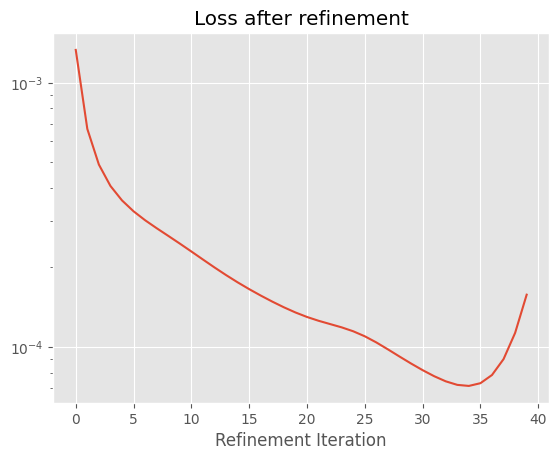

In [54]:
from LM_Solve import refine_solution

reg_sequence = jnp.hstack([
    10**(jnp.arange(-3.,-5,-0.05)),
    ])

p_adjusted,refinement_losses = refine_solution(params,EqnModel,reg_sequence = reg_sequence)

plt.plot(refinement_losses)
plt.xlabel("Refinement Iteration")
plt.title("Loss after refinement")
plt.yscale('log')

In [14]:
#analyze_hessian(hess_loss(p_adjusted),gradloss(p_adjusted))

In [55]:
u_sols = EqnModel.get_u_params(p_adjusted)
P_sol = EqnModel.get_P_params(p_adjusted)

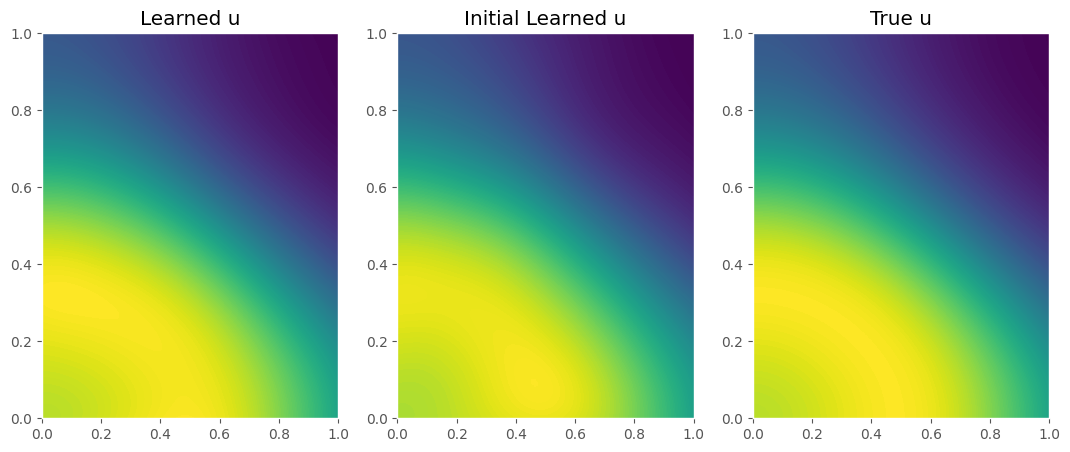

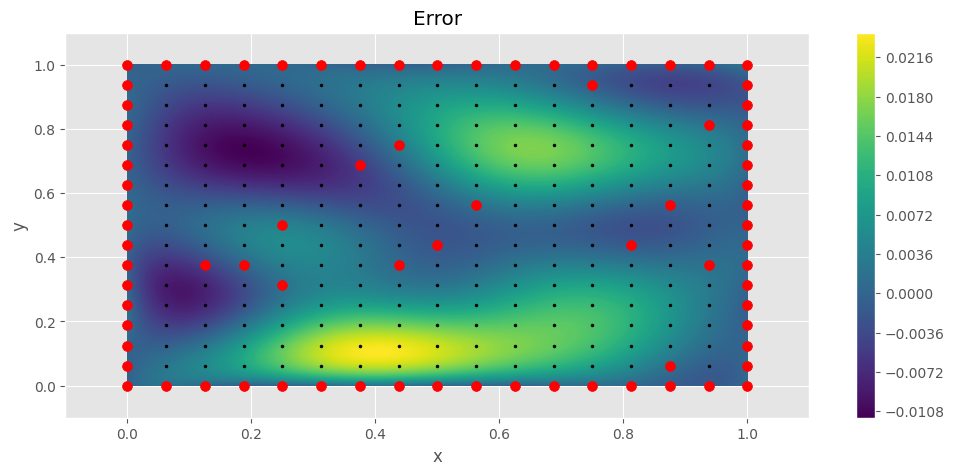

In [56]:
num_fine_grid = 100
x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid),np.linspace(0,1,num_fine_grid))
xy_grid_fine = np.vstack([x_fine.flatten(),y_fine.flatten()]).T


u_eval_fine =u_models[0].point_evaluate(xy_grid_fine,u_sols[0])
u_eval_fine_init = u_models[0].point_evaluate(xy_grid_fine,all_u_params_init[0])

u_true_fine = u_true_function1(xy_grid_fine[:,0],xy_grid_fine[:,1])
plt.figure(figsize=(13,5))
plt.subplot(1,3,1)
plt.title("Learned u")
plt.tricontourf(xy_grid_fine[:,0],xy_grid_fine[:,1],u_eval_fine,200)

plt.subplot(1,3,2)
plt.title("Initial Learned u")
plt.tricontourf(xy_grid_fine[:,0],xy_grid_fine[:,1],u_eval_fine_init,200)

plt.subplot(1,3,3)
plt.title("True u")
plt.tricontourf(xy_grid_fine[:,0],xy_grid_fine[:,1],u_true_fine,200)
plt.show()
plt.figure(figsize = (12,5))
plt.title("Error")
plt.tricontourf(xy_grid_fine[:,0],xy_grid_fine[:,1],u_true_fine-u_eval_fine,250)
plt.colorbar()
plt.scatter(xy_all[:,0],xy_all[:,1],c='black',s = 4)
plt.scatter(xy_obs1[:,0],xy_obs1[:,1],c='red',s = 50)

plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.show()

In [57]:
def get_nrmse(true,pred):
    return jnp.sqrt(jnp.mean((true-pred)**2)/jnp.mean(true**2))

u_true_functions = [u_true_function1,u_true_function2,u_true_function3]
for i in range(3):
    model = u_models[i]
    sol = u_sols[i]
    init_params = all_u_params_init[i]
    u_eval_fine =model.point_evaluate(xy_grid_fine,sol)
    u_eval_fine_init = model.point_evaluate(xy_grid_fine,init_params)

    u_true_fine = u_true_functions[i](xy_grid_fine[:,0],xy_grid_fine[:,1])

    print(f"Results on function {i}")
    print("Optimized model: ",get_nrmse(u_true_fine,u_eval_fine))
    print("Two Step model: ",get_nrmse(u_true_fine,u_eval_fine_init))

Results on function 0
Optimized model:  0.004168949016894511
Two Step model:  0.008315862371381412
Results on function 1
Optimized model:  0.008486444073585528
Two Step model:  0.018928581889270463
Results on function 2
Optimized model:  0.011217352318652563
Two Step model:  0.00902830411902009


In [58]:
u1_model = u_models[0]
u1_sol = u_sols[0]


num_fine_grid = 50
x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
xy_fine_int = np.vstack([x_fine.flatten(),y_fine.flatten()]).T

u_true_interior = u_true_function1(xy_fine_int[:,0],xy_fine_int[:,1])

model_grid_features_all = EqnModel.get_stacked_eqn_features(u_sols)

model_fine_features_u = u1_model.evaluate_operators(feature_operators,xy_fine_int,u1_sol).reshape(len(xy_fine_int),len(feature_operators),order = 'F')
evaluation_u = u1_model.evaluate_operators(feature_operators,xy_fine_int,u1_sol)
grid_features_u = evaluation_u.reshape(len(xy_fine_int),len(feature_operators),order = 'F')
model_fine_features = jnp.hstack([xy_fine_int,grid_features_u])


P_preds_model_features = P_model.kernel_function(model_fine_features,model_grid_features_all)@P_sol

init_P_features = EqnModel.get_stacked_eqn_features(all_u_params_init)

K = P_model.kernel_function(init_P_features,init_P_features)

P_params_naive = solve(K+1e-5*diagpart(K),EqnModel.stacked_collocation_rhs)

init_fine_features_u = u1_model.evaluate_operators(feature_operators,xy_fine_int,all_u_params_init[0]).reshape(len(xy_fine_int),len(feature_operators),order = 'F')
evaluation_u = u1_model.evaluate_operators(feature_operators,xy_fine_int,u1_sol)
grid_features_u = evaluation_u.reshape(len(xy_fine_int),len(feature_operators),order = 'F')
init_fine_features = jnp.hstack([xy_fine_int,grid_features_u])

P_preds_init_model_features_init = P_model.kernel_function(init_fine_features,init_P_features)@P_params_naive

In [59]:
def get_nrmse(true,pred):
    return jnp.sqrt(jnp.mean((true-pred)**2)/jnp.mean(true**2))

print("Optimized model feature predictions ",get_nrmse(eval_rhs1(xy_fine_int),P_preds_model_features))
print("2 Step model feature predictions ",get_nrmse(eval_rhs1(xy_fine_int),P_preds_init_model_features_init))

Optimized model feature predictions  0.0007816294159951551
2 Step model feature predictions  0.20265466228541892


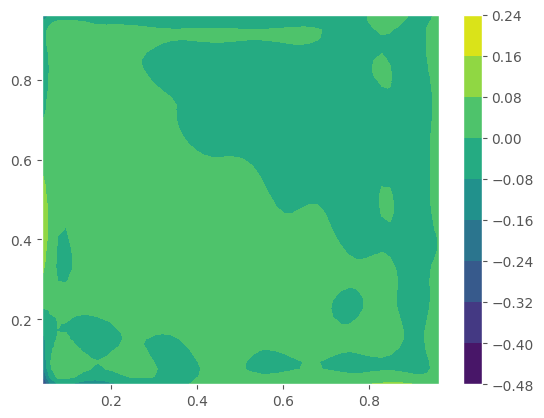

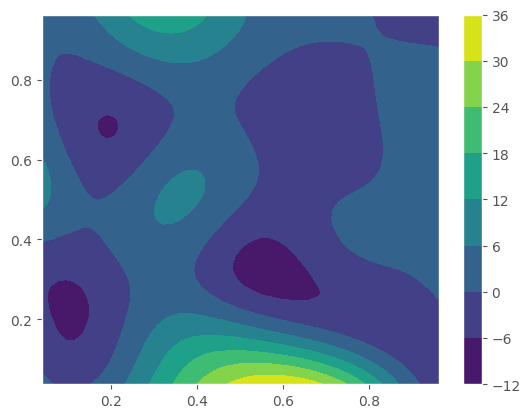

In [60]:
plt.tricontourf(xy_fine_int[:,0],xy_fine_int[:,1],eval_rhs1(xy_fine_int)-P_preds_model_features)
plt.colorbar()
plt.show()
plt.tricontourf(xy_fine_int[:,0],xy_fine_int[:,1],eval_rhs1(xy_fine_int)-P_preds_init_model_features_init)
plt.colorbar()
plt.show()


In [ ]:
sigma_perm = 0.3
def g_perm(x1,x2):
    return jnp.exp(-((x1 - 0.4)**2 + (x2 - 0.5)**2)/(2*sigma_perm**2))
def permeability_function(x):
    return 1.3 - g_perm(x[0],x[1])

def P(x,y,u):
    def inside(stuff):
        return permeability_function(jnp.array([stuff[0],stuff[1]])) * grad(u)(jnp.array([stuff[0],stuff[1]]))
    return jnp.trace(jacrev(inside)(jnp.array([x,y])))

In [ ]:
def u_example(x):
    return jnp.sin(x[0] + x[1])

def u_example_fake(x,y):
    return jnp.sin(x[0] + x[1])


def Pfunc(x):
    return P(x[0],x[1],u_example)

Pvec = jax.vmap(Pfunc)

truth = Pvec(xy_int)

In [ ]:
@jit
def evaluate_function_features(x):
    return [op(u_example_fake,0)(jnp.array([x[0],x[1]]),jnp.array([0,0])) for op in feature_operators]

vec_eval = jax.vmap(evaluate_function_features)

In [ ]:
test_features_u = jnp.array(vec_eval(xy_int)).T
test_features = jnp.hstack([xy_int,test_features_u])

In [ ]:
get_nrmse(truth,P_model.predict(test_features,P_sol))

In [ ]:
get_nrmse(truth,P_model.predict(test_features,P_params_naive))

In [ ]:
plt.tricontourf(xy_fine[:,0],xy_fine[:,1],permeability_function(xy_fine[:,0],xy_fine[:,1]))
plt.colorbar()